### Exploratory plots for different gappy strategies

In [14]:
import numpy as np 
import numpy.ma as ma
import scipy
print(np.__version__)
print(scipy.__version__)
import tqdm
import pandas as pd
import random
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

1.22.3
1.7.3


#### Functions

In [3]:
def model(t, theta): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t-T0)
    rv = -K * np.sin(arg)
    
    return rv

def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    #print("partial mu, partial K: ", partial_mu(t, theta, 'K'))
    #print("partial mu, partial P: ", partial_mu(t, theta, 'P'))
    #print("partial mu, partial T0: ", partial_mu(t, theta, 'T0'))
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        for j in range(len(theta)):
            #param_i = theta[i]
            #param_j = theta[j]
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed
            #print(factor1)
            ###factor2 = 1/sigma**2 # inverse of covariance matrix (or just the RV variance if held constant)
            ###factor2[factor2 == np.inf] = 0 # turn infs into zeros (shouldn't it be nans?)
            #print(factor2)
            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter
            #print(factor3)
            #print("shapes: ", factor1.shape, factor2.shape, factor3.shape)
            #print(np.dot(np.dot(factor1, factor2), factor3))
            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

def calculate_fim_faster(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix by calculating partial derivatives only once
    and then plugging them into the right places. 
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    partial_k = partial_mu(t, theta, 'K')
    partial_p = partial_mu(t, theta, 'P')
    partial_t = partial_mu(t, theta, 'T0')
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        wrt_i = param_list[i]
        if wrt_i=='K':
            factor1 = partial_k
        elif wrt_i=='P':
            factor1 = partial_p
        elif wrt_i=='T0':
            factor1 = partial_t
        
        for j in range(len(theta)):
            wrt_j = param_list[j]
            if wrt_j=='K':
                factor3 = partial_k
            elif wrt_j=='P':
                factor3 = partial_p
            elif wrt_j=='T0':
                factor3 = partial_t
                            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

def calculate_fim_array(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix using np.stack instead of nested for loop
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    partial_k = partial_mu(t, theta, 'K')
    partial_p = partial_mu(t, theta, 'P')
    partial_t = partial_mu(t, theta, 'T0')
    
    #print(np.dot(np.dot(partial_k, factor2), partial_k))
    #print(np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]))
    
    fim = np.stack([np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]),
                  np.array([np.dot(np.dot(partial_p, factor2), partial_k), np.dot(np.dot(partial_p, factor2), partial_p), np.dot(np.dot(partial_p, factor2), partial_t)]),
                  np.array([np.dot(np.dot(partial_t, factor2), partial_k), np.dot(np.dot(partial_t, factor2), partial_p), np.dot(np.dot(partial_t, factor2), partial_t)])])
    
    return fim

def model_jax(t, K, P, T0): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters, but JAXified
    (basically, np --> jnp)
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    #K, P, T0 = theta[0], theta[1], theta[2]
    #normalized_t = (t - T0 % P) % P # thanks, Rae! 
    #arg = (2*jnp.pi/P)*(normalized_t)
    
    arg = (2*jnp.pi/P)*(t-T0)
    rv = -K * jnp.sin(arg)
    
    return rv

def calculate_fim_jax(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix using JAX jacfwd to calculate partial derivatives
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    jac = jax.jacfwd(model_jax, argnums=[1,2,3])
    partials = np.array(jac(test_t, float(test_K), float(test_P), float(test_T0)))
    partial_k = partials[0]
    partial_p = partials[1]
    partial_t = partials[2]
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        wrt_i = param_list[i]
        if wrt_i=='K':
            factor1 = partial_k
        elif wrt_i=='P':
            factor1 = partial_p
        elif wrt_i=='T0':
            factor1 = partial_t
        
        for j in range(len(theta)):
            wrt_j = param_list[j]
            if wrt_j=='K':
                factor3 = partial_k
            elif wrt_j=='P':
                factor3 = partial_p
            elif wrt_j=='T0':
                factor3 = partial_t
                            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

@jax.jit
def dfms_jax_version(t, sigma, theta): # thanks, Dan! 
    """
    Calculate the generalized Fisher Information Matrix using JAX Jacobian.
    Generalizable to arbitrary parameters.
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    def inner(params):
        return model_jax(t, params[0], params[1], params[2])
    
    factor = jnp.where(sigma > 0, 1/sigma**2, 0)    
    J = factor @ jax.jacobian(inner)(theta)
    
    return J.T @ J

In [4]:
### free parameters from Langellier et al 2020
# let's hold these constant for now, but maybe we should sample from the given uncertainties later?
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
Prot = 28.1 # solar rotation period; days
sigma_qp_s = 1.43e-3 # correlated noise amplitude
sigma_wn_s = 0.178e-3 # white noise amplitude

def cov_matrix(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_s: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_s: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_s, sigma_wn_s = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = np.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (np.sin(np.pi * (t[i] - t[j])/Prot))**2
            arg = -term1 - term2
            k[i][j] = np.exp(arg)
    
    K = sigma_qp_s**2 * k + sigma_wn_s**2 * np.diag(np.ones(len(t)))
    
    return K

def cov_matrix_jax(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_s: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_s: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_s, sigma_wn_s = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = jnp.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (jnp.sin(jnp.pi * (t[i] - t[j])/Prot))**2
            arg = -term1 - term2
            #k[i][j] = jnp.exp(arg)
            k = jnp.exp(arg)
            #k = k.at[i]
            #x = x.at[idx].set(y)
    
    K = sigma_qp_s**2 * k + sigma_wn_s**2 * jnp.diag(np.ones(len(t)))
    #print("shape: ", K.shape)
    
    return K

params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]

In [5]:
### priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 8.3 #10 # days
start = 2352

test_theta = [test_K, test_P, test_T0]

def make_t(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(start, end, n_obs, endpoint=False)
    #print(start, end, n_obs, t)
    
    # add jitter ~ N(0, 1 hr) to timestamps
    t += np.random.normal(0, 1./24)

    return t

def make_t_without_jitter(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(2300, end, n_obs, endpoint=False)
    
    return t

def strategy(start, n_obs, cadence, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)bb
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
        sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        
        fim = calculate_fim(t, sigma, theta)
        #print("FIM: ", fim)
        #print("det: ", det(fim))
        inv_fim = inv(fim)
        #print("inv: ", inv_fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        #print("sigma_K, using inv: ", sigma_k)
        #sigma_ks.append(sigma_k)
        sigma_k_stable = np.sqrt(1/fim[0][0])
        #print("sigma_K, not using inv: ", sigma_k_stable)

        # np.linalg.solve is more stable than np.linalg.inv, apparently
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM
        
        fim = calculate_fim(t, sigma, theta)
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        sigma_k_stable = np.sqrt(1/fim[0][0])
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim

@jax.jit
def dfms_jax_version(t, sigma, theta): # thanks, Dan! 
    def inner(model_params):
        return model_jax(t, model_params[0], model_params[1], model_params[2])
    
    sigma += 1e-6 # add jitter
    factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) # take inverse of covariance matrix
    #factor = jnp.linalg.inv(sigma)
    #factor = jnp.where(sigma > 0, sigma_inv, 0)  
    
    J = jax.jacobian(inner)(theta)
    
    return J.T @ factor @ J

@jax.jit
def jax_fim(t, sigma, theta, stellar_params): 
    """
    Calculate the generalized Fisher Information Matrix using JAX Jacobian.
    Generalizable to arbitrary parameters.
    Now, with second term for correlated noise. 
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - stellar_params: correlated stellar noise parameters, a la Langellier et al 2021; np.array
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    stellar_params breakdown: 
    - Tau: active region lifetime [days]
    - eta: smoothing parameter
    - Prot: rotation period [days]
    - sigma_qp_s: correlated noise amplitude
    - sigma_wn_s: white noise amplitude
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    def inner(params):
        return model_jax(t, params[0], params[1], params[2])
    
    def inner_sigma(t, params):
        return cov_matrix_jax(t, params)
    
    sigma += 1e-6 # add jitter
    factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) # take inverse of covariance matrix
    #factor = jnp.linalg.inv(sigma)
    #factor = jnp.where(sigma > 0, sigma_inv, 0)  
    
    J = jax.jacobian(inner)(theta)
    first_term = J.T @ factor @ J
    
    S = jax.jacobian(inner_sigma)(t, stellar_params)
    print("factor: ", factor, factor.shape) # 30 x 30
    print("S: ", S, S.shape) # 30 x 30 x 30
          
    trace_of = factor @ S @ factor @ S
    print("trace of: ", trace_of, trace_of.shape)
    
    second_term = 0.5 * jnp.trace(trace_of)
    print(first_term, first_term.shape)
    print(second_term, second_term.shape)
    
    return first_term + second_term

def strategy_jax(start, n_obs, cadence, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
        sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        
        args = t, sigma, jnp.array(theta, dtype=float)
        fim = dfms_jax_version(*args).block_until_ready()
        
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        
        return fim[0][0], sigma_k
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM
        
        args = t, sigma, jnp.array(theta, dtype=float)
        fim = dfms_jax_version(*args).block_until_ready()
        
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        
        return fim[0][0], sigma_k

print(strategy(start=start, n_obs=100, cadence=1, theta=test_theta, sigma_val=30)) # default to 2300

(0.00015752202054739774, 0.0001574770939656835, 0.00015752202054739774, array([[ 4.03241495e+07,  1.27796053e+09, -2.57821898e+05],
       [ 1.27796053e+09,  2.16880221e+14,  2.91410400e+13],
       [-2.57821898e+05,  2.91410400e+13,  5.82747365e+12]]))


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_1289/2524423991.py:82: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_1289/2027747029.py:94: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_1289/2027747029.py:102: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


In [6]:
@jax.jit
def clam_jax_fim(t, sigma, theta): 
    """
    Calculate the generalized Fisher Information Matrix using JAX Jacobian.
    Generalizable to arbitrary parameters.
    Now, with second term for correlated noise. 
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - stellar_params: correlated stellar noise parameters, a la Langellier et al 2021; np.array
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    def inner(params):
        return model_jax(t, params[0], params[1], params[2])
    
    sigma += 1e-6 # add jitter
    factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) # take inverse of covariance matrix
    #factor = jnp.linalg.inv(sigma)
    #factor = jnp.where(sigma > 0, sigma_inv, 0)  
    
    J = jax.jacobian(inner)(theta)
    return J.T @ factor @ J
    

In [7]:
def remove(l,n):
    """
    Remove n points from array l
    """
    
    return np.sort(random.sample(list(l),int(len(l)*(1-n))))

def gappy(n_obs, cadence, start, offs=[], dropout=0.):
    """
    Specify how many nights in a row to observe and how many nights in a row to skip,
    eg. input: {nights on, cadence, percentage of completed observations} 
    
    Input: 
    - n_obs: number of observations to make; this is a fixed goal [int]
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    - offs: all pairs of off-night spans, described by their start/end times [list of two-element lists of floats]
    - dropout: percent of dropout due to weather and other uniformly distributed unfortunate events
    
    Output:
    - observation times: ndarray of floats
    
    """
    
    total_t = []
    start_temp = start
    n_tot = 0
    n = 0
    
    if len(offs) > 0:
        # keep making observations until you've reached your prescribed budget of observations
        while n_tot < n_obs:
            # allow for multiple spans of off nights
            for off in offs:

                end_temp = off[0]

                # rearrange from end = start + n_obs * cadence to get on chunk
                n = int(np.ceil((end_temp - start_temp)/cadence))
                #print(" start: ", start_temp, "end: ", end_temp, "n_obs: ", n)

                try: # if off != offs[-1]: # if there are yet more offs? 
                    t = np.linspace(start_temp, end_temp, n, endpoint=False)
                    # add jitter ~ N(0, 1 hr) to timestamps
                    t += np.random.normal(0, 1./24)
                    total_t = np.concatenate([total_t, t])
                    n_remaining = n_obs - len(total_t)

                except: # if there aren't, then we just straight shot til n_obs is fulfilled
                    #n_remaining = n_obs - len(total_t)
                    #print("exception")
                    end_temp = start_temp + n_remaining * cadence
                    #print(start_temp, end_temp, n_remaining)
                    t = np.linspace(start_temp, end_temp, n_remaining, endpoint=False)

                    # add jitter ~ N(0, 1 hr) to timestamps
                    t += np.random.normal(0, 1./24)

                    #total_t.append(t)
                    total_t = np.concatenate([total_t, t])

                #print(t)

                # new start time
                start_temp = off[1]

                n_tot = len(total_t)
                #print("N total: ", n_tot)

                if n_tot >= n_obs:
                    break

            # let's say there's no more offs and yet more observations to make
            # Then, we just straight shot til n_obs is fulfilled          

        # pare down total_t if the last concatenation overshoots n_obs
        # I have logic for dealing with that if I get through all off nights
        # But n_obs gets hit before then, this is to take care of that.
        n_extra = n_tot - n_obs
        #print("n extra: ", n_extra)
        if n_extra > 0:
            total_t = total_t[:-n_extra]
    
    else:
        total_t = make_t(n_obs, cadence, start)
        #print("total: ", total_t)
    
    # dropout some observations based on dropout
    total_t = remove(total_t, dropout)
    
    return total_t

#### Visualize RV curve with arbitrary observations

In [29]:
### AU Mic and AU Mic b params: Zicher et al 2022: https://academic.oup.com/mnras/article/512/2/3060/6547782
p = 8.5 # p_c = 18.9 days
Prot = 4.86
K = 580 # cm/s
K_err = 250 # cm/s
T0 = 2360 # BJD

theta = [K, p, T0]

n_obs = 30 # 9
cadence = 2
start = 2352
dropout = 0.1
offs = [[start+14, start+28], [start+42, start+56], [start+70, start+84]]
strat = gappy(n_obs = n_obs, cadence = cadence, start = start, offs = offs, dropout = dropout)
#strat = gappy(n_obs = n_obs, cadence = cadence, start = start)



/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_44703/1101555960.py:9: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


FIM:  [[2.2359710e+07 6.7056548e+09 1.9121024e+07]
 [6.7056451e+09 7.0109758e+14 4.5283644e+13]
 [1.9119888e+07 4.5283635e+13 4.2355298e+12]]
sigma_k using linalg.inv:  0.00021240661


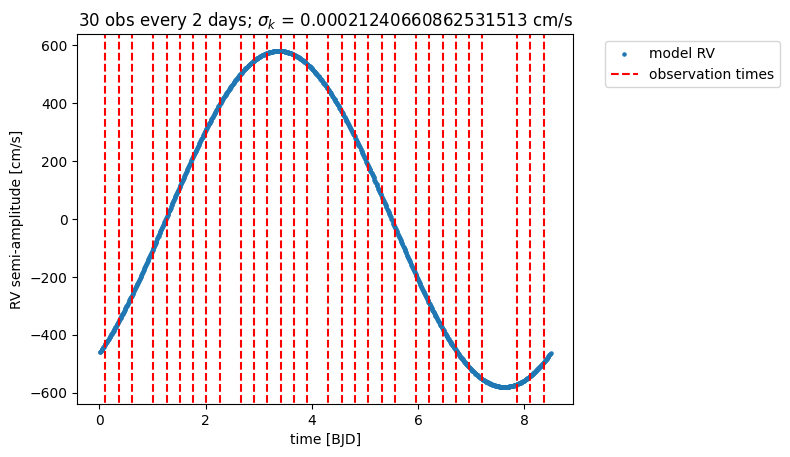

In [18]:
sigma = cov_matrix(strat, params)
sigma += 1e-6 
#sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

args = np.array(strat), sigma, jnp.array(theta, dtype=float)
fim = clam_jax_fim(*args).block_until_ready()

inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]
        
#sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
#print("sigma_k using linalg.solve: ", sigma_k_solve)
#print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2352 # BJD
end = 2452 # BJD
t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
t_phase_folded = t % p
#sigma_val = 30+1e-6 # cm/s
#test_sigma = np.ones(len(test_t))*sigma_val
y = model(t, theta)
y_phase_folded = model(t_phase_folded, theta)

### plot observations from strategy
#end = start + cadence * n_obs
#strat = np.linspace(start, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = np.array(strat) % p

plt.scatter(t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.show()

### Sensitivity maps

#### nights on vs baseline: mask, or more precisely, remove 

Testing mechanism

In [60]:
# planet observation parameters
#periods = np.linspace(1, 30, 200)
#cadences = np.linspace(1, 7, 200)

# static correlated noise parameters
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
sigma_qp_s = 1.43e-3 # correlated noise amplitude [km/s]
sigma_wn_s = 0.178e-3 # white noise amplitude [km/s]
Prot = 2 # 2, 8 days

### the parameter I'm varying
#Tau = 5 # 5, 30, 50, 100
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]

#periods = [p]
#cadences = np.linspace(0.30, 6.85, 100)
#n_obs = 30 #40 # 500
start = 2352
n_obs = 30
n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
baselines = np.linspace(30, 180, 150) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_obs = np.linspace(1, 100, 100) # number of observations

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_stable = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_solve = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
fi_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))

### build strategy based on baseline
strat = np.arange(start, start+baselines[0], 1)
print(strat)
print(len(strat), strat[-1]-strat[0])

### NOW, poke holes in strategy based on offs and dropout
offs = [[start+14, start+21], [start+35, start+42], [start+56, start+70]]
print("offs: ", offs)

for off in offs:
    off_start, off_end = off[0], off[1]
    off_mask = np.arange(off_start, off_end, 1)
    strat = np.setdiff1d(strat, off_mask)
    
print("masked strat: ", strat)
print("length of strat: ", len(strat))                
                          

[2352. 2353. 2354. 2355. 2356. 2357. 2358. 2359. 2360. 2361. 2362. 2363.
 2364. 2365. 2366. 2367. 2368. 2369. 2370. 2371. 2372. 2373. 2374. 2375.
 2376. 2377. 2378. 2379. 2380. 2381.]
30 29.0
offs:  [[2366, 2373], [2387, 2394], [2408, 2422]]
masked strat:  [2352. 2353. 2354. 2355. 2356. 2357. 2358. 2359. 2360. 2361. 2362. 2363.
 2364. 2365. 2373. 2374. 2375. 2376. 2377. 2378. 2379. 2380. 2381.]
length of strat:  23


Real thing: front-load off nights

In [84]:
print(n_offs)
print((n_offs % o))
o = 2
off_start = start+o
off_end = off_start + (n_offs % o)
np.arange(off_start, off_end, 1)

10
0


array([], dtype=int64)

In [138]:
#n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
#baselines = np.linspace(31, 180, 150) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_ons = np.linspace(3, 16, 14)
#baselines = np.linspace(35, 60, 26) 

# planet observation parameters
#periods = np.linspace(1, 30, 200)
#cadences = np.linspace(1, 7, 200)

# static correlated noise parameters
Tau = 50 #23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
sigma_qp_s = 1.43e-3 # correlated noise amplitude [km/s]
sigma_wn_s = 0.178e-3 # white noise amplitude [km/s]
sigma_qp_s = sigma_qp_s * 1e5 # [cm/s]
sigma_wn_s = sigma_wn_s * 1e5 # [cm/s]
Prot = 28 # 2, 8, 14, 28 days
p = 8.5 # 8.5, 14.1, 28.1
K = 500 # cm/s

### the parameter I'm varying
#Tau = 5 # 5, 30, 50, 100
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]

#periods = [p]
#cadences = np.linspace(0.30, 6.85, 100)
#n_obs = 30 #40 # 500
start = 2352
n_obs = 30
n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
baselines = np.linspace(30, 180, 151) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_obs = np.linspace(1, 100, 100) # number of observations

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_stable = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_solve = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
fi_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))

for enum_b, b in enumerate(tqdm(baselines)):
    for enum_o, o in enumerate(n_ons):
        
        ### arrange ingredients for strategy
        b, o = int(b), int(o)
        
        n_offs = int(b-n_obs)
        
        n_off_periods = int(np.ceil(n_offs/o))
               
        theta = [K, p, T0]
        #strat = gappy(n_obs = n_obs, cadence = cadence, start = start, offs = offs, dropout = dropout)
        
        ### populate time series
        strat = np.arange(start, start+b, 1)
        
        """
        print("ons: ", o, "baseline:", b)
        print("total nights off: ", n_offs)
        print("number of off periods: ", n_off_periods)
        print("original strat: ", strat)
        """
        
        ### construct off mask
        offs = []
        temp_start = start
        for i in range(n_off_periods):
            off_start = temp_start + o
            if i+1 < n_off_periods: 
                off_end = off_start + o
            elif i+1 == n_off_periods: # last off period
                if n_offs % o == 0: # it means I need to just add o
                    off_end = off_start + o
                else:
                    off_end = off_start + (n_offs % o)
                
            off = np.arange(off_start, off_end, 1)
            offs.append(off)
            
            temp_start += (o+len(off))
        
        ### flatten list
        offs = [item for sublist in offs for item in sublist]
    
        strat = np.setdiff1d(strat, offs)
        
        """
        print("offs: ", offs)
        print("masked strat: ", strat)
        print("length of strat: ", len(strat))
        """
        
        ### calculate FI and sigma_K
        if len(strat) == 30:
            sigma = cov_matrix(strat, params)
            sigma += 1e-6 
            #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

            args = np.array(strat), sigma, jnp.array(theta, dtype=float)
            #fim = dfms_jax_version(*args).block_until_ready()
            fim = clam_jax_fim(*args).block_until_ready()
            inv_fim = inv(fim)
            sigma_k = np.sqrt(inv_fim)[0][0]

            fi_k = fim[0][0]

            # for 2D plots and testing
            sigma_ks[enum_b][enum_o] = sigma_k
            ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
            ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

            fi_ks[enum_b][enum_o] = fi_k
            
        else: 
            #print("nights on: ", o, "baseline: ", b)
            #print("offs: ", offs)
            sigma_ks[enum_b][enum_o] = np.nan
            fi_ks[enum_b][enum_o] = 0
        

  0%|                                                                                                                                               | 0/151 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_1289/1406048588.py:106: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:03<00:00, 45.66it/s]


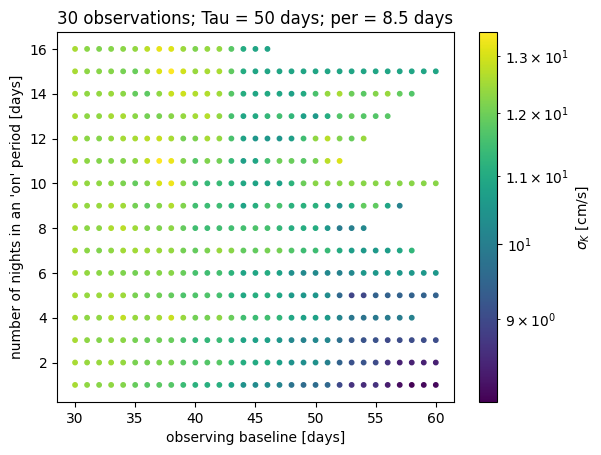

In [139]:
x, y = np.meshgrid(n_ons, baselines)
#plt.scatter(x, y, c=np.sqrt(fi_ks), s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
plt.scatter(y, x, c=sigma_ks, s=10, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r'$\sqrt{FI_K}$')
cbar.ax.set_ylabel(r'$\sigma_K$ [cm/s]')
plt.ylabel("number of nights in an 'on' period [days]")
plt.xlabel("observing baseline [days]")
#plt.yscale('log')
#plt.title(f"{n_obs} observations; Prot = {Prot} days; per = {p} days")
plt.title(f"{n_obs} observations; Tau = {Tau} days; per = {p} days")
plt.savefig("plots/regimes/on_vs_baseline_tau50_p8.png", format="png")
plt.show()

Balanced distribution of off nights

In [234]:
def on_vs_baseline_balanced_mask(start, n_obs, on, baseline, perfect_flag=True):
    """
    Construct observing strategy given on nights, baseline, and n_obs.
    Distribute off nights evenly across time series.
    
    Inputs: 
    - start: start date [BJD]
    - n_obs: number of observations budgeted for
    - on: number of consecutive nights of observation [days]
    - baseline: overall observing window [days]
    - perfect_flag: if True, only make strategies for combos that have equal numbers of offs in each block
      if False, make strategies for any combo that has off periods = on periods - 1
    
    Returns: 
    - strat: time series of dates of observations [list of floats]
    
    """
    
    # (4, 60)
    temp_start = start
    
    # 8
    n_on_periods = np.ceil(n_obs/on) 
    
    # skip combinations that don't necessitate a perfectly balanced strat
    #print(baseline - n_obs, n_on_periods - 1, (baseline - n_obs) % (n_on_periods - 1))
    if perfect_flag == True:    
        if (baseline - n_obs) % (n_on_periods - 1) != 0: 
            strat = []
            #print("baseline: ", baseline, "on: ", on)
            return strat
    # at the very least, skip combinations that don't have off periods = on periods - 1
    
    # 7
    n_mixed_periods = int(n_on_periods - 1)
    
    # 8
    block_length = int(np.floor((baseline - on)/n_mixed_periods))
    # 4 
    off_length = block_length - on
    
    # 28
    on_total = int(n_mixed_periods * on)
    # 56
    nights_total = int(n_mixed_periods * block_length)
    
    # 2
    on_residual = n_obs - on_total
    # 4
    nights_residual = baseline - nights_total
    
    """
    strat = []
    for i in range(n_mixed_periods):
        mixed_block = np.arange(temp_start, temp_start+on, 1)
        
        strat.append(mixed_block)
    
        temp_start += block_length # includes on and off
    """
    ### make canvas to poke holes in
    strat = np.arange(start, start + baseline, 1)
    
    """
    print("ons: ", on, "baseline:", baseline)
    print("mixed periods: ", n_mixed_periods)
    print("block length: ", block_length)
    print("off length: ", off_length)
    print("on total: ", on_total)
    print("nights total: ", nights_total)
    print("on residual: ", on_residual)
    print("nights residual: ", nights_residual)
    print("original strat: ", strat)
    """
    
    ### construct off masks
    offs = []
    for i in range(n_mixed_periods):
        off = np.arange(temp_start + on, temp_start + block_length, 1)
        offs.append(off)
                        
        temp_start += block_length # includes on and off
                        
    ### recurse until residuals are resolved
    #while nights_residual < baseline:
    
    ### if we have residual off nights, pack them in from the front
    if nights_residual - on_residual > 0:
        for i in range(nights_residual - on_residual):
            offs[i] = np.append(offs[i], offs[i][-1] + 1) # add an extra night
    
    ### flatten list
    offs = [item for sublist in offs for item in sublist]
    
    strat = np.setdiff1d(strat, offs)
      
    """
    print("offs: ", offs)
    print("length of offs: ", len(offs))
    print("masked strat: ", strat)
    print("length of strat: ", len(strat))
    """
    
    return strat

strat = on_vs_baseline_balanced_mask(start, n_obs, 4, 60, perfect_flag=False)
print(strat)

[2352 2353 2354 2355 2361 2362 2363 2369 2370 2371 2376 2377 2378 2379
 2384 2385 2386 2387 2392 2393 2394 2395 2400 2401 2402 2403 2408 2409
 2410 2411]


In [247]:
def on_vs_baseline_balanced(start, n_obs, on, baseline, perfect_flag=True):
    """
    Construct observing strategy given on nights, baseline, and n_obs.
    Distribute on nights across time series while meeting the prescription.
    
    Inputs: 
    - start: start date [BJD]
    - n_obs: number of observations budgeted for
    - on: number of consecutive nights of observation [days]
    - baseline: overall observing window [days]
    - perfect_flag: if True, only make strategies for combos that have equal numbers of offs in each block
      if False, make strategies for any combo that has off periods = on periods - 1
    
    Returns: 
    - strat: time series of dates of observations [list of floats]
    
    """
    
    # (4, 60)
    temp_start = start
    
    # 8
    n_on_periods = int(np.ceil(n_obs/on))
    
    # skip combinations that don't necessitate a perfectly balanced strat
    #print(baseline - n_obs, n_on_periods - 1, (baseline - n_obs) % (n_on_periods - 1))
    if perfect_flag == True:    
        if (baseline - n_obs) % (n_on_periods - 1) != 0: 
            strat = []
            #print("baseline: ", baseline, "on: ", on)
            return strat
    # at the very least, skip combinations that don't have off periods = on periods - 1
    
    # 7
    n_mixed_periods = int(n_on_periods - 1)
    
    # 8
    #block_length = int(np.floor((baseline - on)/n_mixed_periods))
    block_length = int(np.floor((baseline - n_obs)/n_mixed_periods))
    
    # 4 
    off_length = block_length - on
    
    # 28
    on_total = int(n_mixed_periods * on)
    # 56
    nights_total = int(n_mixed_periods * block_length)
    
    # 2
    on_residual = n_obs - on_total
    # 4
    nights_residual = baseline - nights_total
    
    ### make canvas to poke holes in
    strat = np.arange(start, start + baseline, 1)
    
    #"""
    print("ons: ", on, "baseline:", baseline)
    print("mixed periods: ", n_mixed_periods)
    print("block length: ", block_length)
    print("off length: ", off_length)
    print("on total: ", on_total)
    print("nights total: ", nights_total)
    print("on residual: ", on_residual)
    print("nights residual: ", nights_residual)
    print("original strat: ", strat)
    #"""
    
    ### construct on 'masks'
    ons = []
    for i in range(n_mixed_periods):
        on_i = np.arange(temp_start, temp_start + on, 1)
        ons.append(on_i)
                        
        temp_start += block_length # includes on and off
                        
    ### last on block to top off
    ons.append(np.arange(temp_start, temp_start + on_residual, 1))
    
    ### flatten list
    ons = [item for sublist in ons for item in sublist]
    
    #"""
    print("ons: ", ons)
    print("length of ons: ", len(ons))
    #"""
    
    return ons

strat = on_vs_baseline_balanced(start, n_obs, 12, 60, perfect_flag=False)
print(strat)

ons:  12 baseline: 60
mixed periods:  2
block length:  15
off length:  3
on total:  24
nights total:  30
on residual:  6
nights residual:  30
original strat:  [2352 2353 2354 2355 2356 2357 2358 2359 2360 2361 2362 2363 2364 2365
 2366 2367 2368 2369 2370 2371 2372 2373 2374 2375 2376 2377 2378 2379
 2380 2381 2382 2383 2384 2385 2386 2387 2388 2389 2390 2391 2392 2393
 2394 2395 2396 2397 2398 2399 2400 2401 2402 2403 2404 2405 2406 2407
 2408 2409 2410 2411]
ons:  [2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2382, 2383, 2384, 2385, 2386, 2387]
length of ons:  30
[2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2382, 2383, 2384, 2385, 2386, 2387]


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_1289/450341035.py:9: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


FIM:  [[ 7.86125101e-03 -1.62376285e-01  1.19484641e-01]
 [-1.62387848e-01  1.87188266e+05  9.65216895e+03]
 [ 1.19482666e-01  9.65216992e+03  1.02989563e+03]]
sigma_k using linalg.inv:  11.300775


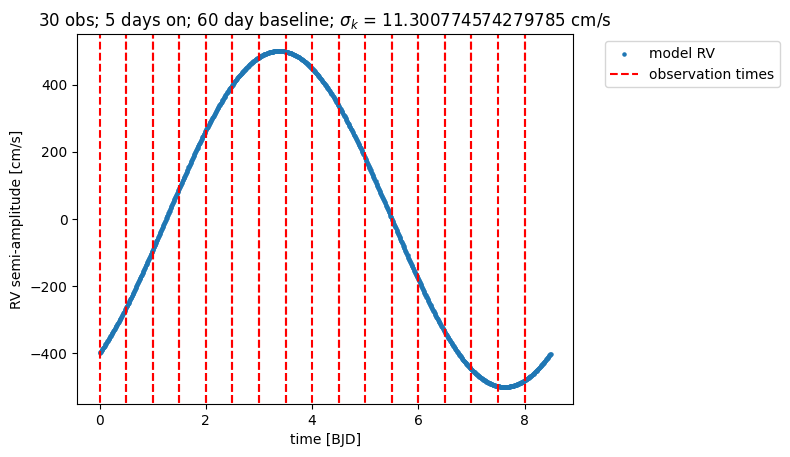

In [237]:
sigma = cov_matrix(strat, params)
sigma += 1e-6 
#sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

args = np.array(strat), sigma, jnp.array(theta, dtype=float)
fim = clam_jax_fim(*args).block_until_ready()

inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]
        
#sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
#print("sigma_k using linalg.solve: ", sigma_k_solve)
#print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2352 # BJD
end = 2552 # BJD
t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
t_phase_folded = t % p
#sigma_val = 30+1e-6 # cm/s
#test_sigma = np.ones(len(test_t))*sigma_val
y = model(t, theta)
y_phase_folded = model(t_phase_folded, theta)

### plot observations from strategy
#end = start + cadence * n_obs
#strat = np.linspace(start, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = np.array(strat) % p

plt.scatter(t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs; 5 days on; 60 day baseline; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('plots/regimes/strategy_5on_60baseline_imperfect.png', format='png')
plt.show()

In [ ]:
#n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
#baselines = np.linspace(31, 180, 150) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_ons = np.linspace(3, 16, 14)
#baselines = np.linspace(35, 60, 26) 

# planet observation parameters
#periods = np.linspace(1, 30, 200)
#cadences = np.linspace(1, 7, 200)

# static correlated noise parameters
Tau = 50 #23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
sigma_qp_s = 1.43e-3 # correlated noise amplitude [km/s]
sigma_wn_s = 0.178e-3 # white noise amplitude [km/s]
sigma_qp_s = sigma_qp_s * 1e5 # [cm/s]
sigma_wn_s = sigma_wn_s * 1e5 # [cm/s]
Prot = 28 # 2, 8, 14, 28 days
p = 8.5 # 8.5, 14.1, 28.1
K = 500 # cm/s

### the parameter I'm varying
#Tau = 5 # 5, 30, 50, 100
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]

#periods = [p]
#cadences = np.linspace(0.30, 6.85, 100)
#n_obs = 30 #40 # 500
start = 2352
n_obs = 30
n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
baselines = np.linspace(30, 180, 151) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_obs = np.linspace(1, 100, 100) # number of observations

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_stable = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_solve = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
fi_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))

for enum_b, b in enumerate(tqdm(baselines)):
    for enum_o, o in enumerate(n_ons):
        
        b, o = int(b), int(o)
        
        try:
            strat = on_vs_baseline_balanced(start, n_obs, o, b, perfect_flag=False)
            #print("strat: ", strat, "length: ", len(strat))
        
            ### calculate FI and sigma_K
            if len(strat) == 30:
                sigma = cov_matrix(strat, params)
                sigma += 1e-6 
                #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

                args = np.array(strat), sigma, jnp.array(theta, dtype=float)
                #fim = dfms_jax_version(*args).block_until_ready()
                fim = clam_jax_fim(*args).block_until_ready()
                inv_fim = inv(fim)
                sigma_k = np.sqrt(inv_fim)[0][0]

                fi_k = fim[0][0]

                # for 2D plots and testing
                sigma_ks[enum_b][enum_o] = sigma_k
                ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
                ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

                fi_ks[enum_b][enum_o] = fi_k

            else: 
                #print("nights on: ", o, "baseline: ", b)
                #print("offs: ", offs)
                sigma_ks[enum_b][enum_o] = np.nan
                fi_ks[enum_b][enum_o] = 0
                
        except Exception as e:
            #print(e, b, o)
            sigma_ks[enum_b][enum_o] = np.nan
            fi_ks[enum_b][enum_o] = 0

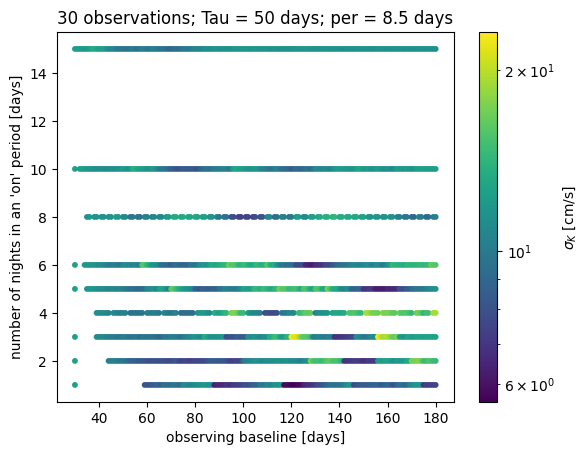

In [236]:
x, y = np.meshgrid(n_ons, baselines)
#plt.scatter(x, y, c=np.sqrt(fi_ks), s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
plt.scatter(y, x, c=sigma_ks, s=10, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r'$\sqrt{FI_K}$')
cbar.ax.set_ylabel(r'$\sigma_K$ [cm/s]')
plt.ylabel("number of nights in an 'on' period [days]")
plt.xlabel("observing baseline [days]")
#plt.yscale('log')
#plt.title(f"{n_obs} observations; Prot = {Prot} days; per = {p} days")
plt.title(f"{n_obs} observations; Tau = {Tau} days; per = {p} days")
plt.savefig("plots/regimes/on_vs_baseline_tau50_p8_balanced_imperfect.png", format="png")
plt.show()

#### nights on vs baseline: building blocks

In [ ]:
# planet observation parameters
#periods = np.linspace(1, 30, 200)
#cadences = np.linspace(1, 7, 200)

# static correlated noise parameters
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
sigma_qp_s = 1.43e-3 # correlated noise amplitude [km/s]
sigma_wn_s = 0.178e-3 # white noise amplitude [km/s]
Prot = 2 # 2, 8 days

### the parameter I'm varying
#Tau = 5 # 5, 30, 50, 100
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]

#periods = [p]
#cadences = np.linspace(0.30, 6.85, 100)
#n_obs = 30 #40 # 500
start = 2352
n_obs = 30
n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
baselines = np.linspace(31, 180, 150) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_obs = np.linspace(1, 100, 100) # number of observations

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_stable = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_solve = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
fi_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))

for enum_b, b in enumerate(tqdm(baselines)):
    for enum_o, o in enumerate(n_ons):
        
        ### arrange ingredients for strategy
        b, o = int(b), int(o)
        #print("baseline: ", b)
        print("ons: ", o)
        
        #print(b - n_obs, np.ceil(n_obs/o) - 1)
        n_offs = int(np.floor((b - n_obs)/(np.ceil(n_obs/o) - 1))) # int
        n_on_periods = int(np.ceil(n_obs/o)) # int
        n_off_periods = n_on_periods - 1 # int
        print("nights off in a period: ", n_offs)
        print("number of on periods: ", n_on_periods)
        #print("number of off periods: ", n_off_periods)

        theta = [K, p, T0]
        #strat = gappy(n_obs = n_obs, cadence = c, start = start)
        #strat = gappy(n_obs = n_obs, cadence = cadence, start = start, offs = offs, dropout = dropout)
        
        ### populate time series
        strat = []
        temp_start = start
        for i in range(n_on_periods):
            t = np.arange(temp_start, temp_start+o, 1) 
            strat = np.concatenate([strat, t])
            
            ### move temp_start forward by number of "on" nights
            temp_start = t[-1] + n_offs + 1
            
            ### skip over next N nights
            #strat += n_offs 
        
        ### fine tune time series based on baseline
        strat_range = max(strat) - min(strat)
        if strat_range > b - 1: # if I overshoot
            overshot = int(strat_range - b)
            #print("overshot: ", overshot)
            strat = strat[:-overshot]
            
        elif strat_range < b - 1: # if I undershoot (also minus 1 bc baseline doesn't count last obs)
            undershot = int(b - strat_range)
            t = np.arange(temp_start, temp_start+undershot, 1)
            strat = np.concatenate([strat, t])
        
        ### remove off nights such that n_obs is alwyas 30
        
        
        print("strat: ", strat)
        print("nights on: ", len(strat))
        print("nights spanned: ", max(strat)-min(strat))
        
        ### calculate FI and sigma_K
        sigma = cov_matrix(strat, params)
        sigma += 1e-6 
        #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

        args = np.array(strat), sigma, jnp.array(theta, dtype=float)
        #fim = dfms_jax_version(*args).block_until_ready()
        fim = clam_jax_fim(*args).block_until_ready()
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        
        fi_k = fim[0][0]
        
        # for 2D plots and testing
        sigma_ks[enum_b][enum_o] = sigma_k
        ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
        ###sigma_ks_solve[enum1][enum2] = sigma_k_solve
        
        fi_ks[enum_b][enum_o] = fi_k
    dfadsfadf

#### number of observations vs baseline

Even spacing

In [16]:
# planet observation parameters
#periods = np.linspace(1, 30, 200)
#cadences = np.linspace(1, 7, 200)

# static correlated noise parameters
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
sigma_qp_s = 1.43e-3 # correlated noise amplitude [km/s]
sigma_wn_s = 0.178e-3 # white noise amplitude [km/s]

### the parameter I'm varying
#Tau = 5 # 5, 30, 50, 100
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]

#periods = [p]
#cadences = np.linspace(0.30, 6.85, 100)
#n_obs = 30 #40 # 500
start = 2352
#n_ons = np.linspace(1, 30, 30) # the number of consecutive nights of observing before going to off-mode
baselines = np.linspace(30, 180, 151) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
n_obs = np.linspace(1, 100, 100) # number of observations

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(baselines)*len(n_obs)).reshape((len(baselines),len(n_obs)))
sigma_ks_stable = np.ones(len(baselines)*len(n_obs)).reshape((len(baselines),len(n_obs)))
sigma_ks_solve = np.ones(len(baselines)*len(n_obs)).reshape((len(baselines),len(n_obs)))
fi_ks = np.ones(len(baselines)*len(n_obs)).reshape((len(baselines),len(n_obs)))


for enum_b, b in enumerate(tqdm(baselines)):
    for enum_o, o in enumerate(n_obs):
        
        b, o = int(b), int(o)        
        theta = [K, p, T0]
        #strat = gappy(n_obs = n_obs, cadence = c, start = start)
        #strat = gappy(n_obs = n_obs, cadence = cadence, start = start, offs = offs, dropout = dropout)
        strat = np.linspace(start, start+b, o)
        
        sigma = cov_matrix(strat, params)
        sigma += 1e-6 
        #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

        args = np.array(strat), sigma, jnp.array(theta, dtype=float)
        #fim = dfms_jax_version(*args).block_until_ready()
        fim = clam_jax_fim(*args).block_until_ready()
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        
        fi_k = fim[0][0]
        
        # for 2D plots and testing
        sigma_ks[enum_b][enum_o] = sigma_k
        ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
        ###sigma_ks_solve[enum1][enum2] = sigma_k_solve
        
        fi_ks[enum_b][enum_o] = fi_k
        

  0%|                                                                                                                                               | 0/151 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_46955/3198586509.py:51: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [04:25<00:00,  1.76s/it]


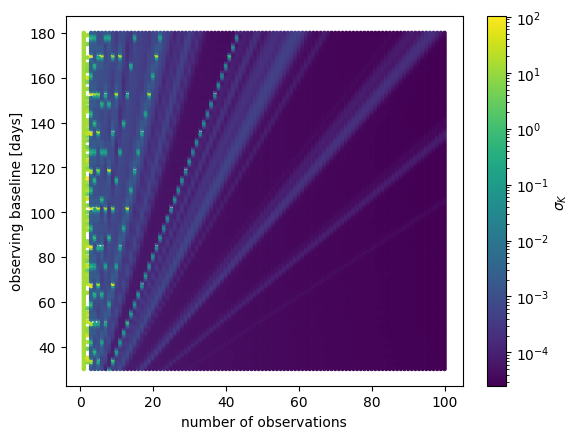

In [23]:
x, y = np.meshgrid(n_obs, baselines)
#plt.scatter(x, y, c=np.sqrt(fi_ks), s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
plt.scatter(x, y, c=sigma_ks, s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r'$\sqrt{FI_K}$')
cbar.ax.set_ylabel(r'$\sigma_K$')
plt.xlabel("number of observations")
plt.ylabel("observing baseline [days]")
#plt.yscale('log')
#plt.title(f"{n_obs} observations; Prot = {Prot} days")
plt.savefig("plots/regimes/even_sigma.pdf", format="pdf")
plt.show()

#### Uneven spacing

In [ ]:
def gappy_baselines(n_obs, baseline, start, offs=[], dropout=0.):
    """
    Prescribe observing strategy, allowing for differing observing baslines.
    Previous gappy() function allowed for differing observing cadences. 
    Allow for arbitrary off nights and random dropout. 
    
    Input: 
    - n_obs: number of observations to make [int]
    - basline: total observing baseline [days; int]
    - start: start time [BJD]
    - offs: all pairs of off-night spans, described by their start/end times [list of two-element lists of floats]
    - dropout: percent of dropout due to weather and other uniformly distributed unfortunate events
    
    Output:
    - observation times: ndarray of floats
    
    """
    
    even = np.linspace(start, baseline, n_obs)
    
    
    return 

In [ ]:
total_t = []
start_temp = start
n_tot = 0
n = 0

if len(offs) > 0:
    # keep making observations until you've reached your prescribed budget of observations
    while n_tot < n_obs:
        # allow for multiple spans of off nights
        for off in offs:

            end_temp = off[0]

            # rearrange from end = start + n_obs * cadence to get on chunk
            n = int(np.ceil((end_temp - start_temp)/cadence))
            #print(" start: ", start_temp, "end: ", end_temp, "n_obs: ", n)

            try: # if off != offs[-1]: # if there are yet more offs? 
                t = np.linspace(start_temp, end_temp, n, endpoint=False)
                # add jitter ~ N(0, 1 hr) to timestamps
                t += np.random.normal(0, 1./24)
                total_t = np.concatenate([total_t, t])
                n_remaining = n_obs - len(total_t)

            except: # if there aren't, then we just straight shot til n_obs is fulfilled
                #n_remaining = n_obs - len(total_t)
                #print("exception")
                end_temp = start_temp + n_remaining * cadence
                #print(start_temp, end_temp, n_remaining)
                t = np.linspace(start_temp, end_temp, n_remaining, endpoint=False)

                # add jitter ~ N(0, 1 hr) to timestamps
                t += np.random.normal(0, 1./24)

                #total_t.append(t)
                total_t = np.concatenate([total_t, t])

            #print(t)

            # new start time
            start_temp = off[1]

            n_tot = len(total_t)
            #print("N total: ", n_tot)

            if n_tot >= n_obs:
                break

        # let's say there's no more offs and yet more observations to make
        # Then, we just straight shot til n_obs is fulfilled          

    # pare down total_t if the last concatenation overshoots n_obs
    # I have logic for dealing with that if I get through all off nights
    # But n_obs gets hit before then, this is to take care of that.
    n_extra = n_tot - n_obs
    #print("n extra: ", n_extra)
    if n_extra > 0:
        total_t = total_t[:-n_extra]

else:
    total_t = make_t(n_obs, cadence, start)
    #print("total: ", total_t)

# dropout some observations based on dropout
total_t = remove(total_t, dropout)

return total_t

In [ ]:
# planet observation parameters
#periods = np.linspace(1, 30, 200)
#cadences = np.linspace(1, 7, 200)

# static correlated noise parameters
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
sigma_qp_s = 1.43e-3 # correlated noise amplitude [km/s]
sigma_wn_s = 0.178e-3 # white noise amplitude [km/s]

### the parameter I'm varying
#Tau = 5 # 5, 30, 50, 100
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]

#periods = [p]
#cadences = np.linspace(0.30, 6.85, 100)
#n_obs = 30 #40 # 500
start = 2352
#n_ons = np.linspace(1, 30, 30) # the number of consecutive nights of observing before going to off-mode
baselines = np.linspace(30, 180, 151) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
n_obs = np.linspace(1, 100, 100) # number of observations

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(baselines)*len(n_obs)).reshape((len(baselines),len(n_obs)))
sigma_ks_stable = np.ones(len(baselines)*len(n_obs)).reshape((len(baselines),len(n_obs)))
sigma_ks_solve = np.ones(len(baselines)*len(n_obs)).reshape((len(baselines),len(n_obs)))
fi_ks = np.ones(len(baselines)*len(n_obs)).reshape((len(baselines),len(n_obs)))


for enum_b, b in enumerate(tqdm(baselines)):
    for enum_o, o in enumerate(n_obs):
        
        b, o = int(b), int(o)        
        theta = [K, p, T0]
        #strat = gappy(n_obs = n_obs, cadence = c, start = start)
        #strat = gappy(n_obs = n_obs, cadence = cadence, start = start, offs = offs, dropout = dropout)
        strat = np.linspace(start, start+b, o)
        
        sigma = cov_matrix(strat, params)
        sigma += 1e-6 
        #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

        args = np.array(strat), sigma, jnp.array(theta, dtype=float)
        #fim = dfms_jax_version(*args).block_until_ready()
        fim = clam_jax_fim(*args).block_until_ready()
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        
        fi_k = fim[0][0]
        
        # for 2D plots and testing
        sigma_ks[enum_b][enum_o] = sigma_k
        ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
        ###sigma_ks_solve[enum1][enum2] = sigma_k_solve
        
        fi_ks[enum_b][enum_o] = fi_k
        
        
